## Sensitivity Analysis
This Notebook investigates the influence of different parameters on the ETP equations implemented in the pyet python package.
Here some functions were written for fast implementation of the sensitivity analysis

In [22]:
import pandas as pd
import matplotlib.pyplot as plt
import pyet
import numpy as np
from scipy import stats
import inspect

## Anmerkungen:

Found bug???? -> elevation should be optional but it isn´t in pyet.pm

In [23]:
#read data
data_16412 = pd.read_csv('klima_daily.csv', index_col=1, parse_dates=True)
data_16412

,station,strahl,rel,t,tmax,tmin,vv
time,,,,,,,
2000-01-01,16412,300.0,80.0,-2.7,0.5,-5.8,1.0
2000-01-02,16412,250.0,86.0,0.2,2.5,-2.1,1.0
2000-01-03,16412,598.0,86.0,0.6,3.6,-2.4,1.0
2000-01-04,16412,619.0,83.0,-0.5,4.5,-5.5,1.0
2000-01-05,16412,463.0,84.0,-0.1,5.4,-5.5,1.0
...,...,...,...,...,...,...,...
2021-11-07,16412,852.0,74.0,8.5,12.2,4.7,1.6
2021-11-08,16412,553.0,78.0,7.5,10.4,4.5,1.6
2021-11-09,16412,902.0,67.0,7.1,11.7,2.4,2.7


In [24]:
# Convert Glabalstrahlung J/cm2 to MJ/m2 by dividing to 100

meteo = pd.DataFrame({"time":data_16412.index, "tmean":data_16412.t, "tmax":data_16412.tmax, "tmin":data_16412.tmin, "rh":data_16412.rel, 
                      "wind":data_16412.vv, "rs":data_16412.strahl/100})
time, tmean, tmax, tmin, rh, wind, rs = [meteo[col] for col in meteo.columns]

# extract the min and max values of each variable in the dataset
# this is used later to create a realistic random distribution of values in the sensitivity analysis
t_min = (min(tmin), max(tmin))
t_max = (min(tmax), max(tmax))
t_mean = (min(tmean), max(tmean))
wind = (min(wind), max(wind))
rs= (min(rs), max(rs))
rh = (min(rh), max(rh))

lat = 47.077778*np.pi/180  # Latitude of the meteorological station, converting from degrees to radians
elevation = 367  # meters above sea-level

lambda1=pyet.calc_lambda(tmean=tmean)  # Latent Heat of Vaporization in PyEt [MJ kg-1] 
lambda0 = 2.45  # Latent Heat of Vaporization in Guo et al., 2016 [MJ kg-1] 
lambda_corr = lambda1 / lambda0  # Correction factor

In [25]:
# function to combine two dicts
def merge_dicts(x, y):
    z = x.copy()   # start with x's keys and values
    z.update(y)    # modifies z with y's keys and values & returns None
    return z

# function to create series from single float value
def create_series_from_float(value):
    """
    Create a pandas series from a single float value and a pandas index.
    """
    #check if value is a float
    if isinstance(value, float or int):
        # convert to array
        value = np.array([value]) 
        
    return pd.Series(value, index = pd.date_range(start = '2018-01-01', periods = len(value), freq = 'D'))

#function to populate dictionary with random values for each parameter
def randomize_parameters(param_dict, num_samples):
    for name, data in param_dict.items():
        param_dict[name] = np.random.uniform(data[0], data[1], num_samples)
    return param_dict

def parameters_2_series(param_dict):
    for name, data in param_dict.items():
        param_dict[name] = create_series_from_float(data)
    return param_dict

def filter_params(func, params):
    # Get a list of parameter names for the function
    valid_params = inspect.signature(func).parameters.keys()
    
    # Filter the dictionary to only include valid parameters
    return {k: v for k, v in params.items() if k in valid_params}

def remove_target_key(target_key, rand_parameters, fixed_params):
    # remove the target parameter from the parameter dictionary
    try:
        del rand_parameters[target_key]
    except KeyError:
        pass

    try:
        del fixed_params[target_key]
    except KeyError:
        pass

    return rand_parameters, fixed_params

def sensitivity_analysis(func, param_name, param_range, rand_parameters, fixed_params, lambda0=2.45, num_samples=200, apply_correction = False):
    """
    Conducts a sensitivity analysis on a given function.

    :param func: The function to test.
    :param param_name: The parameter name as a string that we want to analyze.
    :param param_range: A tuple (min, max) specifying the range of values.
    :param fixed_params: A dictionary of other parameters that will be kept constant.
    :param num_samples: The number of samples which are randomly created for each parameter.
    :return: A list of output values for each sampled value in param_range.
    """
    sampled_values = np.linspace(param_range[0], param_range[1], num_samples)
    results = []
    
    rand_parameters, fixed_params = remove_target_key(param_name, rand_parameters.copy(), fixed_params.copy())

    for value in sampled_values:
        # Update the parameter of interest.
        params = rand_parameters.copy()

        # filter the parameters to only include those that are needed for the function.
        filtered_params = filter_params(func, params.copy())
        fixed_params = filter_params(func, fixed_params.copy())
        
        params_rand_dist = randomize_parameters(filtered_params, num_samples)
        params_rand_dist[param_name] = np.full(num_samples, value)

        params1 = parameters_2_series(params_rand_dist)

        params1 = merge_dicts(params1, fixed_params)

        # Get the result of the function with the current parameter set.
        if apply_correction is False:
            lambda_corr = 1
        else:
            lambda1 = pyet.calc_lambda(params['tmean'])
            lambda_corr = lambda1/lambda0

        result = func(**params1) * lambda_corr
        results.append(result)

        res = np.mean(results, axis=1)
        std = np.std(results, axis=1)

    return res, std, sampled_values


# Penman


In [27]:
# Example usage:
# define a dict which is than used in the sensitivity analysis. The dict provides information about min and max values of different variables.
# This information is later used to create a random sample of values for the sensitivity analysis.
rand_parameters = {
    'tmean': t_mean,
    'tmin': t_min,
    'tmax': t_max,
    'wind': wind,
    'rs': rs,
    'rh': rh,
}

# the fixed parameters do not change during the calcualtion
fixed_parameters = {
    'elevation': 400,
    'aw':1,
    'bw':0.526,
    'albedo': 0.08,
    'lat': 47.077778*np.pi/180,
}

In [29]:
lambda0 = 2.45  # Latent Heat of Vaporization in Guo et al., 2016 [MJ kg-1] 
res1, std1, xaxis1 = sensitivity_analysis(pyet.penman, 'wind', (0.5, 10.5), rand_parameters, fixed_parameters, lambda0, num_samples=400)
res2, std2, xaxis2 = sensitivity_analysis(pyet.penman, 'tmean', (0.5, 20.5), rand_parameters, fixed_parameters, lambda0, num_samples=400)
res3, std3, xaxis3 = sensitivity_analysis(pyet.penman, 'rs', (0.5, 40), rand_parameters, fixed_parameters, lambda0, num_samples=400)
res4, std4, xaxis4 = sensitivity_analysis(pyet.penman, 'rh', (20, 100), rand_parameters, fixed_parameters, lambda0, num_samples=400)

Text(0, 0.5, 'evaporation (mm/day)')

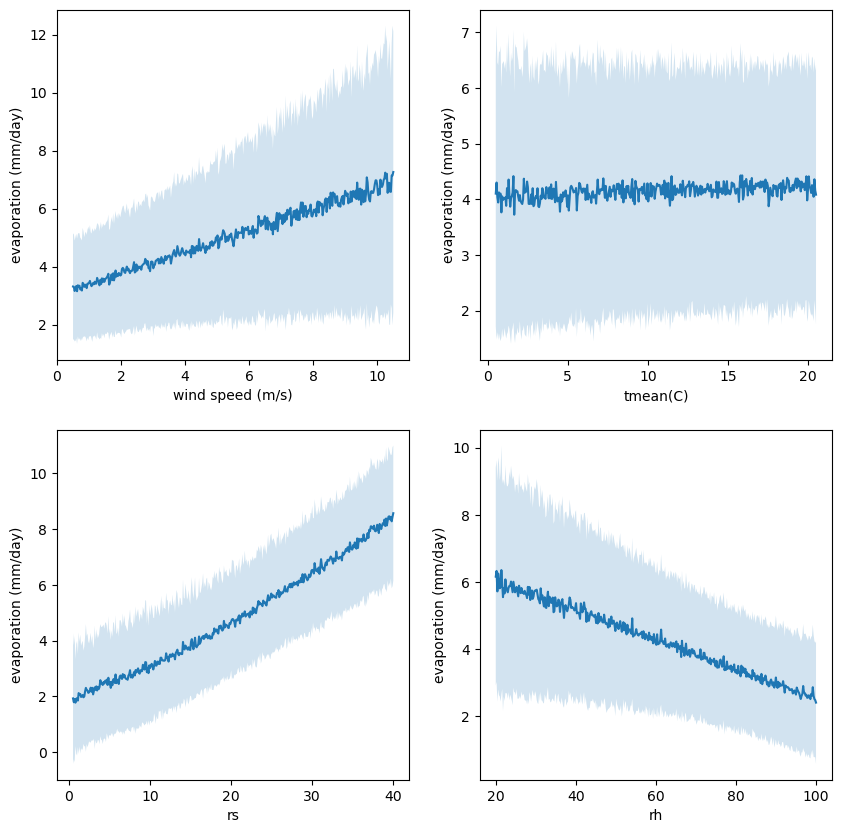

In [30]:
# create 4 subplots
fig, axs = plt.subplots(2, 2, figsize=(10, 10))
axs[0, 0].plot(xaxis1, res1)
axs[0,0].fill_between(xaxis1, res1-std1, res1+std1, alpha=0.2)
#set x and y labels
axs[0,0].set_xlabel('wind speed (m/s)')
axs[0,0].set_ylabel('evaporation (mm/day)')

axs[0,1].plot(xaxis2, res2)
axs[0,1].fill_between(xaxis2, res2-std2, res2+std2, alpha=0.2)
axs[0,1].set_xlabel('tmean(°C)')
axs[0,1].set_ylabel('evaporation (mm/day)')

axs[1,0].plot(xaxis3, res3)
axs[1,0].fill_between(xaxis3, res3-std3, res3+std3, alpha=0.2)
axs[1,0].set_xlabel('rs')
axs[1,0].set_ylabel('evaporation (mm/day)')

axs[1,1].plot(xaxis4, res4)
axs[1,1].fill_between(xaxis4, res4-std4, res4+std4, alpha=0.2)
axs[1,1].set_xlabel('rh')
axs[1,1].set_ylabel('evaporation (mm/day)')


## Penman Monteith

In [31]:
lambda0 = 2.45  # Latent Heat of Vaporization in Guo et al., 2016 [MJ kg-1] 
res1, std1, xaxis1 = sensitivity_analysis(pyet.pm, 'wind', (0.5, 10.5), rand_parameters, fixed_parameters, lambda0, num_samples=400)
res2, std2, xaxis2 = sensitivity_analysis(pyet.pm, 'tmean', (0.5, 20.5), rand_parameters, fixed_parameters, lambda0, num_samples=400)
res3, std3, xaxis3 = sensitivity_analysis(pyet.pm, 'rs', (0.5, 40), rand_parameters, fixed_parameters, lambda0, num_samples=400)
res4, std4, xaxis4 = sensitivity_analysis(pyet.pm, 'rh', (20, 100), rand_parameters, fixed_parameters, lambda0, num_samples=400)

Text(0, 0.5, 'evaporation (mm/day)')

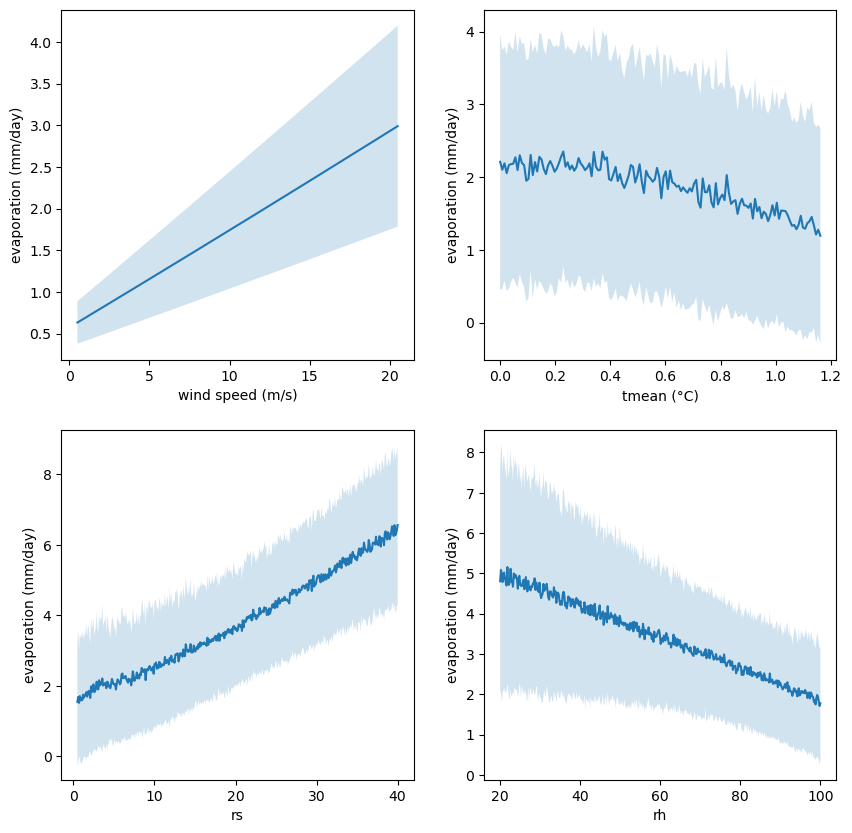

In [36]:
# create 4 subplots
fig, axs = plt.subplots(2, 2, figsize=(10, 10))
axs[0, 0].plot(xaxis1, res1)
axs[0,0].fill_between(xaxis1, res1-std1, res1+std1, alpha=0.2)
#set x and y labels
axs[0,0].set_xlabel('wind speed (m/s)')
axs[0,0].set_ylabel('evaporation (mm/day)')

axs[0,1].plot(xaxis2, res2)
axs[0,1].fill_between(xaxis2, res2-std2, res2+std2, alpha=0.2)
axs[0,1].set_xlabel('tmean (°C)')
axs[0,1].set_ylabel('evaporation (mm/day)')

axs[1,0].plot(xaxis3, res3)
axs[1,0].fill_between(xaxis3, res3-std3, res3+std3, alpha=0.2)
axs[1,0].set_xlabel('rs')
axs[1,0].set_ylabel('evaporation (mm/day)')

axs[1,1].plot(xaxis4, res4)
axs[1,1].fill_between(xaxis4, res4-std4, res4+std4, alpha=0.2)
axs[1,1].set_xlabel('rh')
axs[1,1].set_ylabel('evaporation (mm/day)')

In [33]:
# Example usage:
rand_parameters = {
    'tmean': t_mean,
    'tmin': t_min,
    'tmax': t_max,
    'wind': wind,
    'rs': rs,
    'rh': rh,
}

fixed_parameters = {
    'elevation': 400,
    'aw':1,
    'bw':0.526,
    'albedo': 0.08,
    'lat': 47.077778*np.pi/180,
}

res1, std1, xaxis1 = sensitivity_analysis(pyet.oudin, 'tmean', (0.5, 20.5), rand_parameters, fixed_parameters, lambda0, num_samples=200)
res2, std2, xaxis2 = sensitivity_analysis(pyet.oudin, 'lat', (0.077778*np.pi/180, 90.077778*np.pi/180), rand_parameters, fixed_parameters, lambda0, num_samples=200)

c:\Users\matth\anaconda3\envs\spring_catch\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: invalid value encountered in arccos
  result = getattr(ufunc, method)(*inputs, **kwargs)


## Oudin

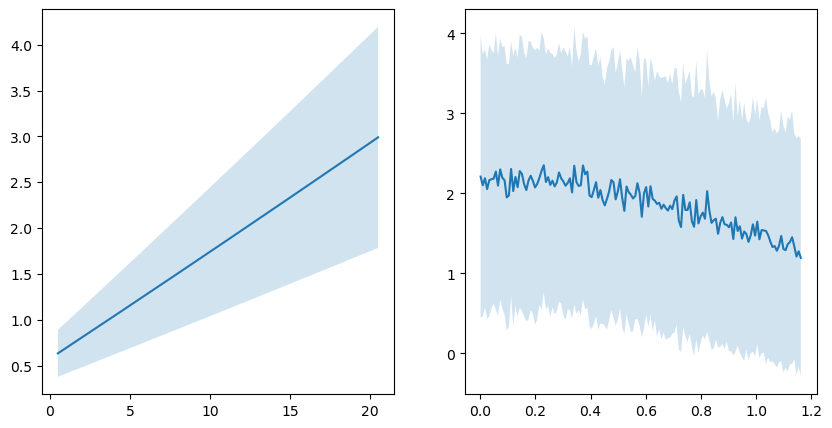

In [34]:
# create 4 subplots
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].plot(xaxis1, res1)
axs[0].fill_between(xaxis1, res1-std1, res1+std1, alpha=0.2)
axs[1,1].set_xlabel('tmean(°C)')
axs[1,1].set_ylabel('evaporation (mm/day)')

axs[1].plot(xaxis2, res2)
axs[1].fill_between(xaxis2, res2-std2, res2+std2, alpha=0.2)
axs[1,1].set_xlabel('lat (°)')
axs[1,1].set_ylabel('evaporation (mm/day)')


## Haude

In [40]:
res1, std1, xaxis1 = sensitivity_analysis(pyet.haude, 'tmean', (0.5, 20.5), rand_parameters, fixed_parameters, lambda0, num_samples=200)
res2, std2, xaxis2 = sensitivity_analysis(pyet.haude, 'rh', (20, 100), rand_parameters, fixed_parameters, lambda0, num_samples=200)

Text(0, 0.5, 'evaporation (mm/day)')

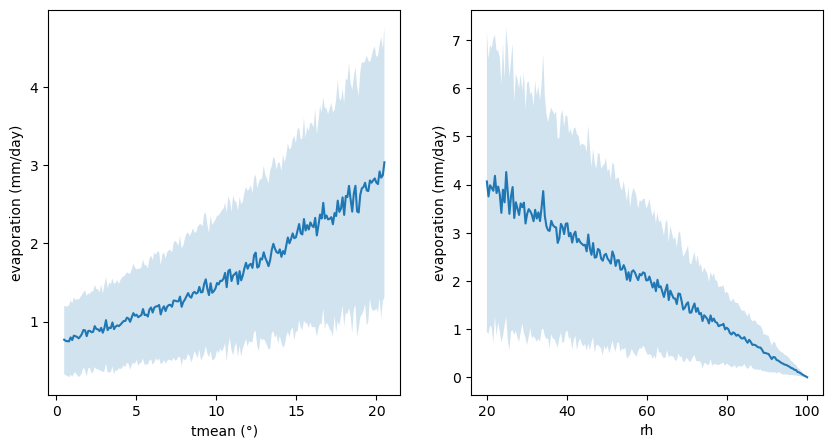

In [46]:
# create 4 subplots
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].plot(xaxis1, res1)
axs[0].fill_between(xaxis1, res1-std1, res1+std1, alpha=0.2)
axs[0].set_xlabel('tmean (°)')
axs[0].set_ylabel('evaporation (mm/day)')

axs[1].plot(xaxis2, res2)
axs[1].fill_between(xaxis2, res2-std2, res2+std2, alpha=0.2)
axs[1].set_xlabel('rh')
axs[1].set_ylabel('evaporation (mm/day)')